# Guassian mixture intra-song clustering for identification of "main" beats

Code for doing tests

In [8]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import math
import librosa

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.embedding import bar_embedding, load_bar_embedding, load_bar_embedding_total, bar_embedding_total
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices


def get_groove_type(key: str):
    return key.split('_')[1].split('/')[0]

def get_reduced_groove_type(key: str):
    return key.split('_')[1].split('/')[0].split('-')[0]



# Some settings
DROP_FILL = True
REDUCED_CATEGORIES = True
REPROCESS = True
SAVE_PROCESSED = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the file and process data using the embedding

In [9]:
import pickle as pkl

with open("data/groovemidi_beatnet_data.pkl","rb") as f:
    bn_data = pkl.load(f)

print(f"{len(bn_data.keys())} groove samples loaded.")

if REPROCESS:

    divs = np.array([3, 4, 6, 8, 9, 12, 16])
    wts = 1/np.sqrt(divs)

    data = {}

    for key in bn_data:
        if DROP_FILL and 'fill' in key:
            print(f"Dropped {key}")
            continue
        
        y, sr = librosa.load(f'{key}.wav')
        proc = smooth_power(y, sr)
        beat_data = bn_data[key]
        db = beat_data[beat_data[:,1] == 1, 0]

        # Some of the tracks are very short; skip them
        if db.shape[0] < 2:
            continue
        embeds = bar_embedding_total(proc/max(abs(proc)), db, divs, sr, kernel_width=30)

        for i, e in enumerate(embeds):
            embeds[i] = embeds[i] * wts[i]

        data[key] = np.concatenate(embeds, axis=1)

    print(f"{len(list(data))} samples processed.")
    if SAVE_PROCESSED:
        with open("data/groovemidi_beatnet_processed_data.pkl","wb+") as f:
            pkl.dump(data, f)
            print("Saved processed data.")

else:
    with open("data/groovemidi_beatnet_processed_data.pkl", "rb") as f:
        data = pkl.load(f)
        print("Loaded processed data.")

1039 groove samples loaded.
Dropped groove-midi/drummer1/session2/38_punk_128_fill_4-4
Dropped groove-midi/drummer1/session2/79_punk_144_fill_4-4
Dropped groove-midi/drummer1/session2/93_funk-rock_92_fill_4-4
Dropped groove-midi/drummer1/session2/121_afrocuban-bembe_122_fill_4-4
Dropped groove-midi/drummer1/session2/165_afrocuban-rhumba_110_fill_4-4
Dropped groove-midi/drummer1/session2/48_punk_128_fill_4-4
Dropped groove-midi/drummer1/session2/117_afrocuban-bembe_122_fill_4-4
Dropped groove-midi/drummer1/session2/95_funk-rock_92_fill_4-4
Dropped groove-midi/drummer1/session2/71_punk_144_fill_4-4
Dropped groove-midi/drummer1/session2/43_punk_128_fill_4-4
Dropped groove-midi/drummer1/session2/109_funk-rock_92_fill_4-4
Dropped groove-midi/drummer1/session2/101_funk-rock_92_fill_4-4
Dropped groove-midi/drummer1/session2/29_country_114_fill_4-4
Dropped groove-midi/drummer1/session2/175_afrocuban-rhumba_110_fill_4-4
Dropped groove-midi/drummer1/session2/131_afrocuban-bembe_122_fill_4-4
Drop

['afrobeat', 'afrocuban', 'blues', 'country', 'dance', 'funk', 'gospel', 'highlife', 'hiphop', 'jazz', 'latin', 'middleeastern', 'neworleans', 'pop', 'punk', 'reggae', 'rock', 'session', 'soul']


/tmp/ipykernel_352731/1629520745.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


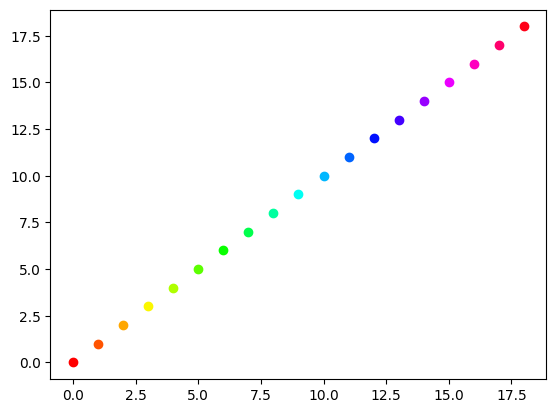

In [10]:
groove_names = set()
for key in bn_data:
    if REDUCED_CATEGORIES:
        groove_names.add(get_reduced_groove_type(key))
    else:
        groove_names.add(get_groove_type(key))
groove_names = list(groove_names)
groove_names.sort()

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


groove_colors = get_cmap(len(groove_names))

for i in range(len(groove_names)):
    plt.scatter([i], [i], color=groove_colors(i))

print(groove_names)

In [11]:
from groove.intraclustering import get_primary_gaussian_mean


if REPROCESS:
    keys = []
    measures = []
    name_indices = []

    for key in data:
        keys.append(key)
        embed = data[key]
        measures.append(get_primary_gaussian_mean(embed))
        if REDUCED_CATEGORIES:
            groove_name = get_reduced_groove_type(key)
        else:
            groove_name = get_groove_type(key)
        name_indices.append(groove_names.index(groove_name))
        
    print(f"Processed {len(measures)} data.")

    if SAVE_PROCESSED:
        with open("data/groovemidi_beatnet_measure_data.pkl","wb+") as f:
            pkl.dump({'keys': np.array(keys), 'measures': np.stack(measures), 'name_indices': np.array(name_indices), 'groove_names': groove_names}, f)
            print("Saved.")
else:
    with open("data/groovemidi_beatnet_measure_data.pkl", "rb") as f:
        temp = pkl.load(f)
        keys = temp['keys']
        measures = temp['measures']
        name_indices = temp['name_indices']
        print("Loaded.")

Processed 396 data.
Saved.


In [13]:
INCLUDE = True
INCLUDE_INDICES = [groove_names.index('jazz'), groove_names.index('rock')]
EXCLUDE_INDICES = []

name_indices = np.array(name_indices)
measures = np.stack(measures)
keys = np.array(keys)

if INCLUDE:
    inds = np.full(name_indices.shape, False)
    for i in INCLUDE_INDICES:
        inds = inds | (name_indices == i)
else:
    inds = np.full(name_indices.shape, True)
    for i in EXCLUDE_INDICES:
        inds = inds & (name_indices != i)

mdata = measures[inds]
ndata = name_indices[inds]
kdata = keys[inds]


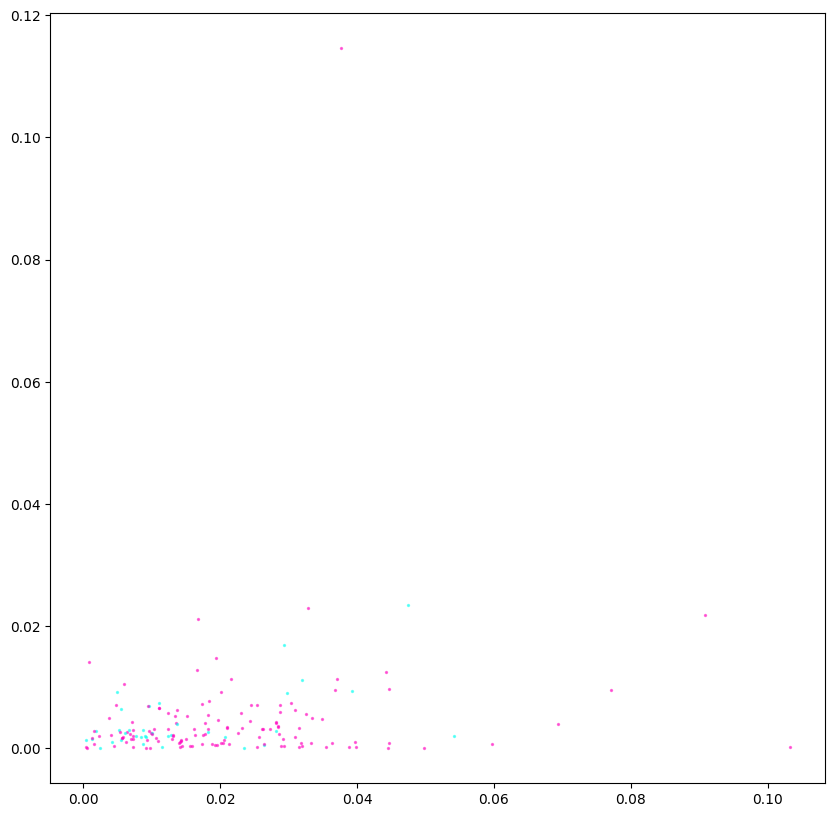

In [14]:
pca = PCA(n_components=2)
pca.fit(mdata)
red_measures = pca.transform(mdata)

plt.figure(figsize=(10,10))

for i in range(len(mdata)):
        plt.scatter(mdata[i,0], mdata[i,1], color=groove_colors(ndata[i]), alpha=0.5, s=2)

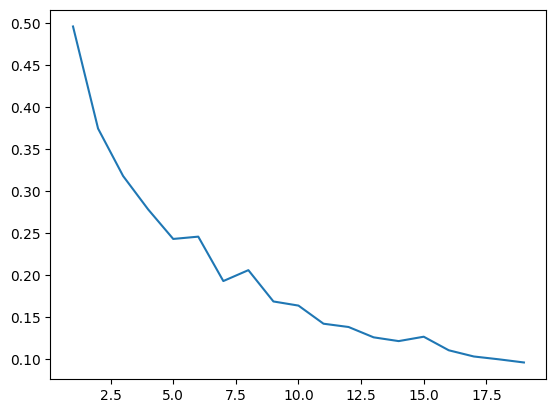

In [19]:
from sklearn.cluster import KMeans

errors = []

for i in range(1, len(groove_names) + 1, 1):
    km = KMeans(n_clusters=i)
    km.fit(mdata)
    errors.append(km.inertia_)


plt.plot(range(1, len(groove_names) + 1, 1), errors)

In [20]:
NUM_CLUSTERS = 2

km = KMeans(n_clusters=NUM_CLUSTERS)
km.fit(mdata)

preds = km.predict(mdata)

pred_dict = {}

for i in range(NUM_CLUSTERS):
    pred_dict[i] = []

for i in range(preds.shape[0]):
    pred_dict[preds[i].item()].append(kdata[i])

In [21]:
pred_dict_cats = {}


for i in range(NUM_CLUSTERS):
    pred_dict_cats[i] = []

for i in range(preds.shape[0]):
    pred_dict_cats[preds[i].item()].append(groove_names[ndata[i]])

for i in range(NUM_CLUSTERS):
    pred_dict_cats[i].sort()

In [22]:
pred_dict_cats

{0: ['jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'jazz',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock